In [1]:
import pandas as pd
import numpy as np
from Higgs.tools.ImplementationUtils import (
    implementChannelLimit,
    read_csv_from_web,
    implementChannelWidthLimit,
    fromHB5Table1,
    readHEPDataCsv,
)
from Higgs import predictions as HP
from Higgs import bounds as HB
from Higgs.tools.LimitValidation import validateChannelLimit, validateChannelWidthLimit
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import MassResolutions as resolution



# CMS 13TeV LHC

## `H > gamgam` light, SM-like [1811.08459](https://arxiv.org/abs/1811.08459)
Note: this is the search with the 96GeV excess

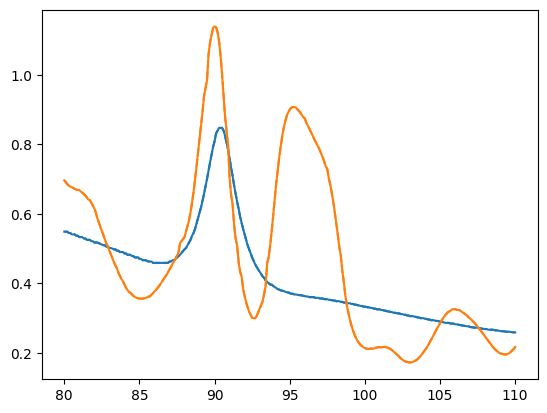

Looks good. Saving this to comb_LHC13_CMS_56.json
using effective coupling input for SM-normalized limit


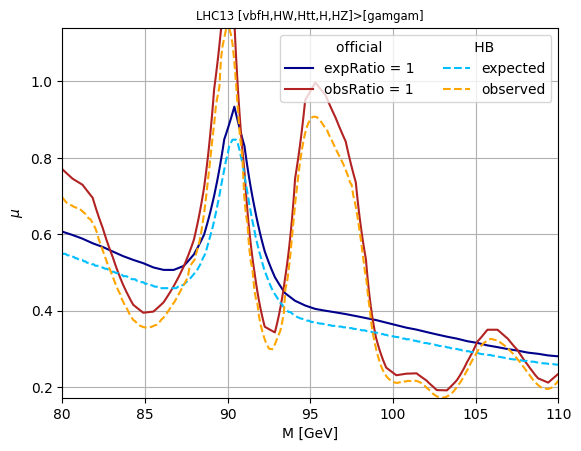

In [2]:
dfExp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1704494/Figure%206/1/csv",
    comment="#",
    skiprows=549,
    names=["m", "exp", "unc+", "unc-"],
)

df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1704494/Figure%206/1/csv",
    comment="#",
    skiprows=10,
    skipfooter=817 - 277,
    engine="python",
    names=["m", "obs"],
)

assert np.allclose(df.m, dfExp.m)
df["exp"] = dfExp.exp
limitFile = implementChannelLimit(
    "1811.08459",
    {"channels": [[p, "gamgam"] for p in ["H", "vbfH", "HZ", "HW", "Htt"]]},
    "https://doi.org/10.17182/hepdata.91266.v1/t7",
    df,
    collider="LHC13",
    luminosity=19.7 + 35.9,  # 8 TeV + 13 TeV
    constraints={"modelLike": "SMHiggsInterp", "process": "signal"},
    massResolution=resolution.gamgam["125"],
    normalization={"reference": "SMHiggsInterp", "process": "signal"},
)
lim = HB.Limit(limitFile)
fig, ax = validateChannelLimit(lim)


# CMS 8TeV LHC

## `H>gamgam` full Run1 hSM combination [CMS-PAS-HIG-13-001](https://cds.cern.ch/record/1530524?ln=en)

No arxiv eprint found.


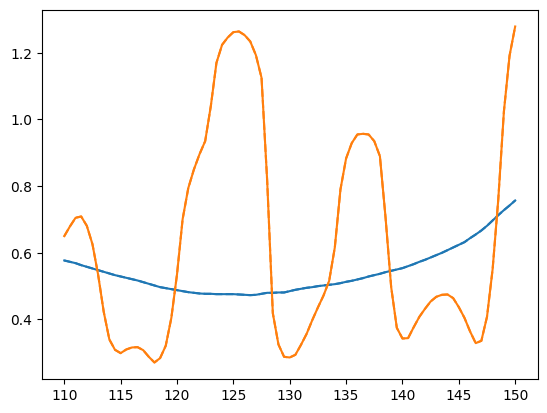

Looks good. Saving this to comb_LHC8_CMS_25.json
using effective coupling input for SM-normalized limit


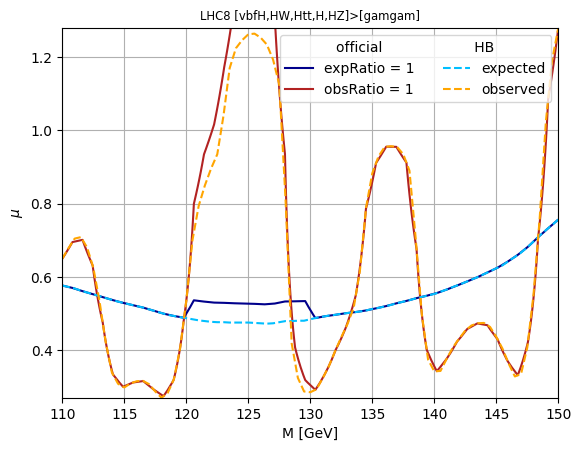

In [3]:
df = fromHB5Table1("13001_CMS_H-gaga_MVA_25fb-1", "CMS")
limitFile = implementChannelLimit(
    1230222,
    {"channels": [[p, "gamgam"] for p in ["H", "vbfH", "HZ", "HW", "Htt"]]},
    "Fig. 5a",
    df,
    constraints={"modelLike": "SMHiggsInterp", "process": "signal"},
    massResolution=resolution.gamgam["125"],
    luminosity=5.1 + 19.6,
    normalization={"reference": "SMHiggsInterp", "process": "signal"},
)
lim = HB.Limit(limitFile)
fig, ax = validateChannelLimit(lim)


## low-mass hSM 8TeV [CMS-PAS-HIG-14-037](https://cds.cern.ch/record/2063739?ln=en)


No arxiv eprint found.


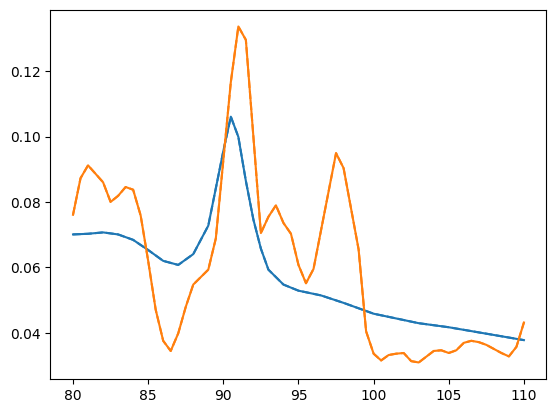

Looks good. Saving this to comb_lowMass_LHC8_CMS_20.json


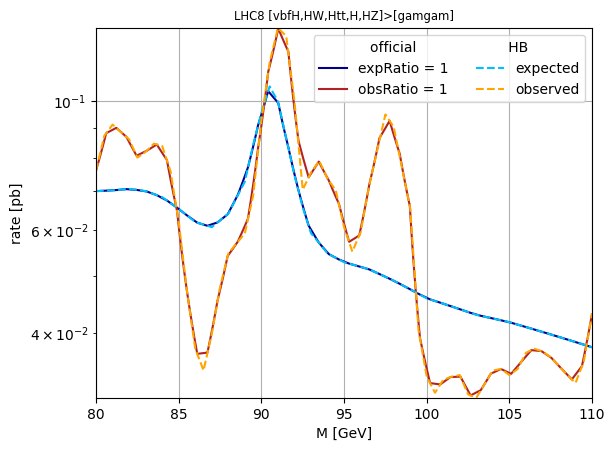

In [4]:
df = fromHB5Table1("14037_CMS_H-gaga_19.7fb-1", "CMS")
prods = ["H", "vbfH", "HZ", "HW", "Htt"]
limitFile = implementChannelLimit(
    1401518,
    {"channels": [[p, "gamgam"] for p in prods]},
    "Fig. 4",
    df,
    massResolution=resolution.gamgam["default"],
    luminosity=19.7,
    prefix="comb_lowMass",
    constraints={"modelLike": "SMHiggs", "process": "signal"},
)
lim = HB.Limit(limitFile)


def smLikeDistributeRate(h, rate):
    smrate = sum(
        (
            HP.SMHiggs(h.mass()).channelRate(lim.collider(), p, "gamgam")
            for p in prods
        )
    )
    HP.effectiveCouplingInput(h, HP.scaledSMlikeEffCouplings(np.sqrt(rate / smrate)))


fig, ax = validateChannelLimit(lim, setAdditionalRates=smLikeDistributeRate)


## high mass `pp>H>gamgam` LHC8, width-dep [1506.02301](https://arxiv.org/abs/1506.02301)


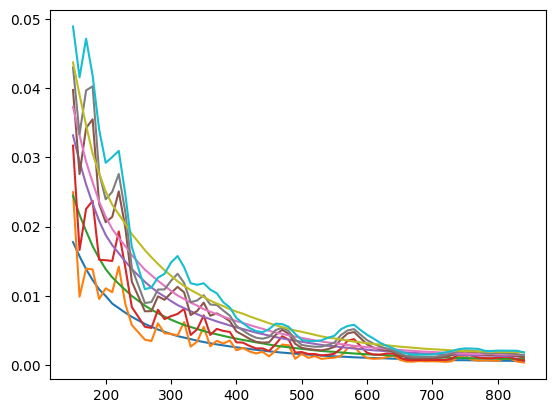

Looks good. Saving this to H_LHC8_CMS_20.json


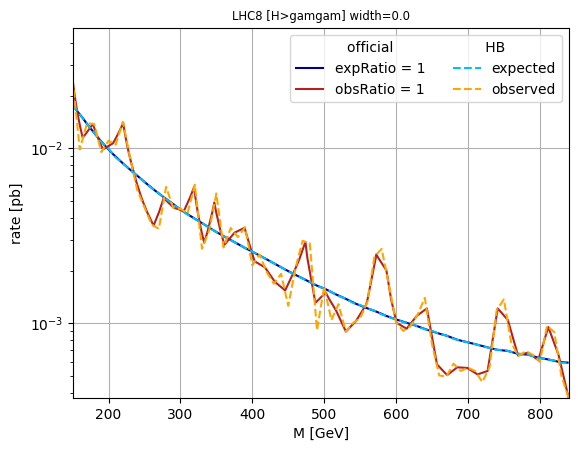

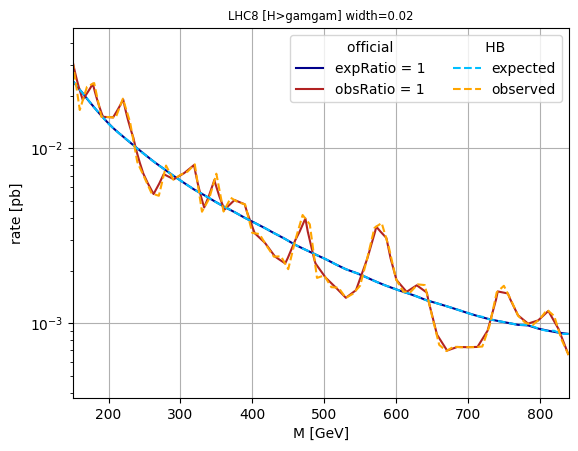

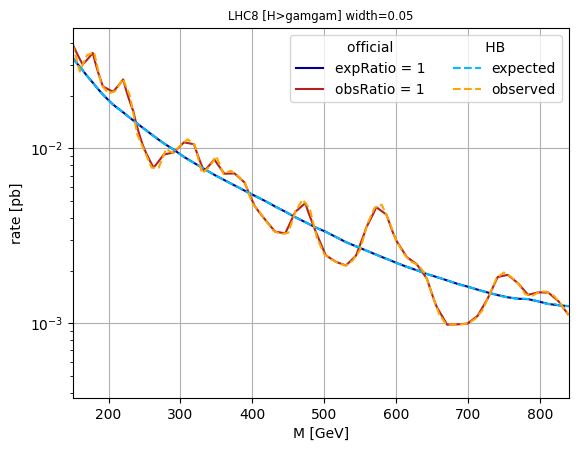

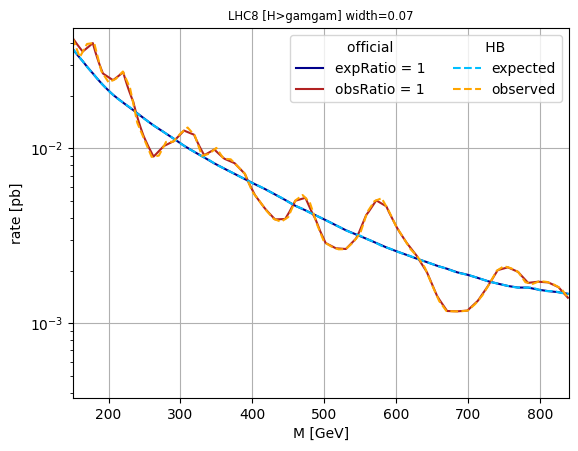

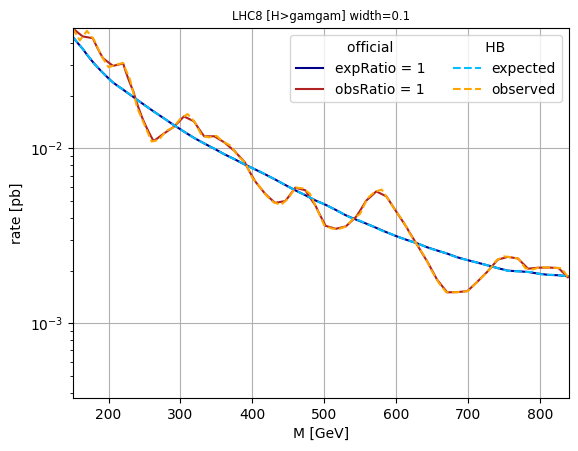

In [5]:
dfExp = read_csv_from_web(
    "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig14006TWiki/limitsResults_2D_Exp.txt",
    sep=r"\s+",
    names=["mass:", "m", "Gamma:", "width", "UL:", "exp"],
)
dfObs = read_csv_from_web(
    "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig14006TWiki/limitsResults_2D_Obs.txt",
    sep=r"\s+",
    names=["mass:", "m", "Gamma:", "width", "UL:", "obs"],
)
assert np.allclose(dfExp.m, dfObs.m)
assert np.allclose(dfExp.width, dfObs.width)
df = dfObs.copy()
df["exp"] = dfExp.exp
del df["mass:"]
del df["Gamma:"]
del df["UL:"]
df.loc[(df.width == 0.1), "width"] = 0
df["normWidth"] = df.width / df.m
df.normWidth = np.round(df.normWidth, 2)

limitFile = implementChannelWidthLimit(
    "1506.02301",
    {"channels": [["H", "gamgam"]]},
    "https://twiki.cern.ch/twiki/bin/view/CMSPublic/Hig14006TWiki",
    df,
    massResolution=resolution.gamgam["default"],
)
lim = HB.Limit(limitFile)
validateChannelWidthLimit(lim)
